# Worksheet 6: Image Classification with CNN and Transfer Learning

## Objective
To classify images into different categories using CNNs and to improve model performance using transfer learning techniques.

## Tasks Breakdown
🔹 **1. Image Classification using CNN (Part A)**
- Build a CNN model from scratch for image classification.

🔹 **2. Transfer Learning for Image Classification (Part B)**
- Use a pre-trained model (like VGG16, ResNet, etc.) for better performance.

## Part A: Image Classification using CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Dataset Loading and Preparation

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [3]:
# Set paths to dataset
dataset_path = "/content/drive/MyDrive/Level 6/AI & ML/Worksheets/Worksheet-5/FruitinAmazon/FruitinAmazon/"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

### 2. Visualize Some Sample Images

Classes in the dataset: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


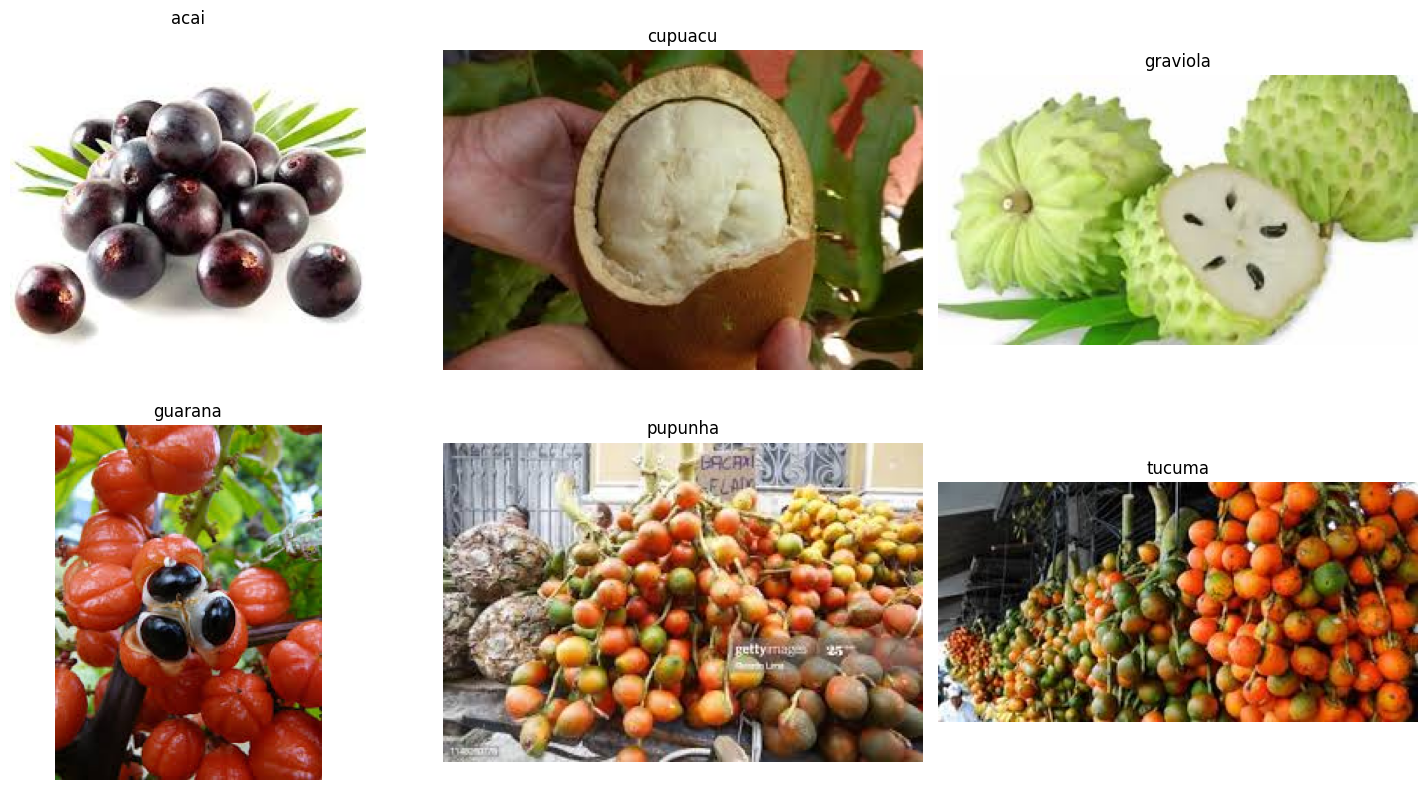

In [4]:
# Get list of class directories from the train folder
class_dirs = sorted(os.listdir(train_dir))
print(f"Classes in the dataset: {class_dirs}")

# Select one image randomly from each class and display
selected_images = []
class_names = []

for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_path)

    # Select a random image from this class
    random_image = random.choice(image_files)
    img_path = os.path.join(class_path, random_image)

    # Open and store the image
    img = Image.open(img_path)
    selected_images.append(img)
    class_names.append(class_name)

# Display the images in a grid format
plt.figure(figsize=(15, 8))
for i, (img, class_name) in enumerate(zip(selected_images, class_names)):
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

### 3. Data Preprocessing and Loading

In [5]:
# Define image parameters
img_height = 224  # Updated to 224 for better compatibility with VGG16
img_width = 224   # Updated to 224 for better compatibility with VGG16
batch_size = 32

# Create a normalization layer
normalization_layer = layers.Rescaling(1./255)

# Load training and validation datasets with validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names before applying transformations
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

# Apply normalization to datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


In [6]:
# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create a more diverse data augmentation layer for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),  # Add contrast variation
    layers.RandomTranslation(0.1, 0.1),  # Add translation in both height and width
    layers.RandomBrightness(0.2),  # Add brightness variation
])

### 4. Build a CNN Model from Scratch

In [7]:
# Build a CNN model
def build_cnn_model():
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Add dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the CNN model
cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,206 (49.36 MB)

 Trainable params: 12,939,206 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Train the CNN Model

In [8]:
# Set up callbacks for model training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create a directory for model checkpoints
checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# In newer versions of TensorFlow, 'period' is replaced with 'save_freq'
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'cnn_model_epoch_{epoch}.keras'),
    save_weights_only=False,
    save_best_only=False,
    save_freq=5*len(train_ds)  # Save every 5 epochs
)

In [9]:
# Train the CNN model
epochs = 30
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.1403 - loss: 3.2211 - val_accuracy: 0.1111 - val_loss: 2.0778
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.1792 - loss: 1.9587 - val_accuracy: 0.1667 - val_loss: 1.8140
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3160 - loss: 1.7140 - val_accuracy: 0.1667 - val_loss: 1.7789
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.2925 - loss: 1.5966 - val_accuracy: 0.1667 - val_loss: 1.7767
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.4694 - loss: 1.4451 - val_accuracy: 0.1667 - val_loss: 1.8663
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5986 - loss: 1.0594 - val_accuracy: 0.2778 - val_loss: 1.7090
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.6368 - loss: 0.9814 - val_accuracy: 0.2778 - val_loss: 1.5009
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6655 - loss: 0.9648 - val_accuracy: 0.4444 - val_loss: 1.2982
Epoch 9/30
3/3

### 6. Evaluate the CNN Model

In [10]:
# Evaluate model on test dataset
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_ds)
print(f"CNN Test accuracy: {cnn_test_acc:.4f}")
print(f"CNN Test loss: {cnn_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6000 - loss: 1.1051
CNN Test accuracy: 0.6000
CNN Test loss: 1.1051


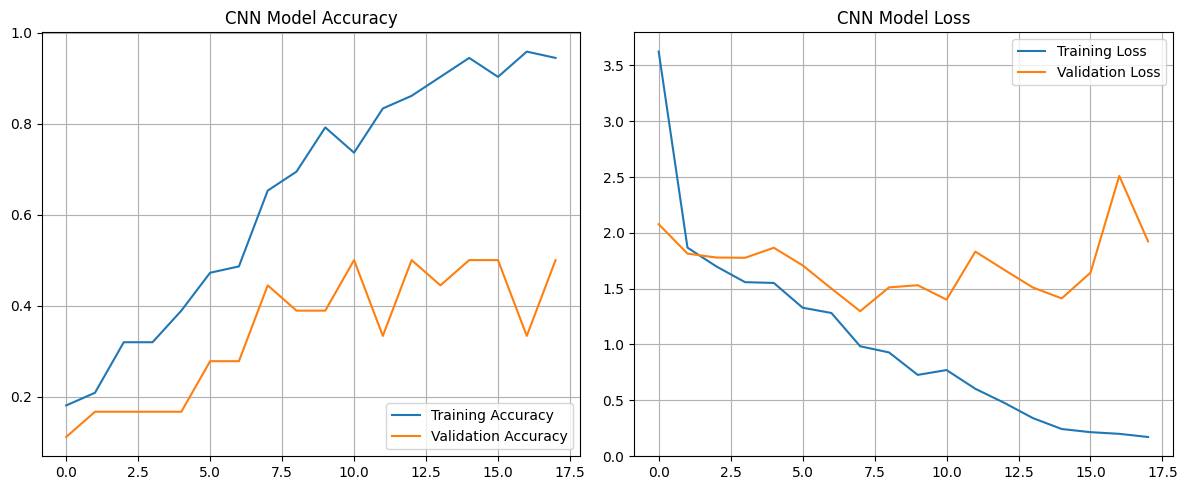

In [11]:
# Plot training history
def plot_training_history(history, title=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot CNN training history
plot_training_history(cnn_history, "CNN Model")

### 7. Make Predictions with CNN Model

In [12]:
# Generate classification report for CNN model
from sklearn.metrics import classification_report

# Get predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = cnn_model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes.numpy())

# Print classification report
print("CNN Model Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
CNN Model Classification Report:
              precision    recall  f1-score   support

        acai       0.80      0.80      0.80         5
     cupuacu       0.25      0.20      0.22         5
    graviola       0.40      0.80      0.53         5
     guarana       0.67      0.80      0.73         5
     pupunha       1.00      0.60      0.75         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.60        30
   macro avg       0.69      0.60      0.60        30
weighted avg       0.69      0.60      0.60        30



In [13]:
# Save the CNN model
cnn_model.save('custom_cnn_model.h5')
print("CNN model saved to 'custom_cnn_model.h5'")

CNN model saved to 'custom_cnn_model.h5'


## Part B: Transfer Learning for Image Classification

### 1. Import a Pre-trained Model

In [14]:
# Import a pre-trained model (VGG16)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the pre-trained model without the classification layers
base_model = VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    include_top=False,   # Don't include the classification layers
    input_shape=(img_height, img_width, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Display base model summary
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### 2. Create a New Model with Transfer Learning

In [15]:
# Build transfer learning model
def build_transfer_model(base_model):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    # Apply data augmentation during training only
    x = data_augmentation(inputs)
    # Preprocess inputs for VGG16
    x = preprocess_input(x)
    # Apply the base model
    x = base_model(x, training=False)
    # Add global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    # Add a dense layer for feature extraction
    x = layers.Dense(256, activation='relu')(x)
    # Add dropout to prevent overfitting
    x = layers.Dropout(0.5)(x)
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = keras.Model(inputs, outputs)
    return model

# Create transfer learning model
transfer_model = build_transfer_model(base_model)

# Compile the model with a higher learning rate
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Slightly higher learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
transfer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 6)              │          1,542 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Create raw datasets for transfer learning (without normalization)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Configure datasets for performance
train_ds_raw = train_ds_raw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_raw = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_raw = test_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.


### 3. Train the Transfer Learning Model

In [17]:
# Train the transfer learning model with the raw datasets
transfer_epochs = 20
transfer_history = transfer_model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=transfer_epochs,
    callbacks=[early_stopping]
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 54s 23s/step - accuracy: 0.0840 - loss: 9.6245 - val_accuracy: 0.2222 - val_loss: 3.6843
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 64s 30s/step - accuracy: 0.2896 - loss: 5.6757 - val_accuracy: 0.2778 - val_loss: 3.7822
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 67s 16s/step - accuracy: 0.3245 - loss: 4.3663 - val_accuracy: 0.2778 - val_loss: 3.3476
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 16s/step - accuracy: 0.2964 - loss: 4.1538 - val_accuracy: 0.2778 - val_loss: 2.6939
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 53s 18s/step - accuracy: 0.4276 - loss: 4.1449 - val_accuracy: 0.2778 - val_loss: 2.0251
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 78s 16s/step - accuracy: 0.4045 - loss: 3.4550 - val_accuracy: 0.4444 - val_loss: 1.4786
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 16s/step - accuracy: 0.5257 - loss: 2.8404 - val_accuracy: 0.7222 - val_loss: 1.2884
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 83s 24s/step - accuracy: 0.7576 - loss: 1.2228 - val_accuracy: 0.7222 - val_loss: 1.2697


### 4. Evaluate the Transfer Learning Model

In [18]:
# Evaluate the transfer learning model
transfer_test_loss, transfer_test_acc = transfer_model.evaluate(test_ds_raw)
print(f"Transfer Learning Test accuracy: {transfer_test_acc:.4f}")
print(f"Transfer Learning Test loss: {transfer_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.8333 - loss: 0.7599
Transfer Learning Test accuracy: 0.8333
Transfer Learning Test loss: 0.7599


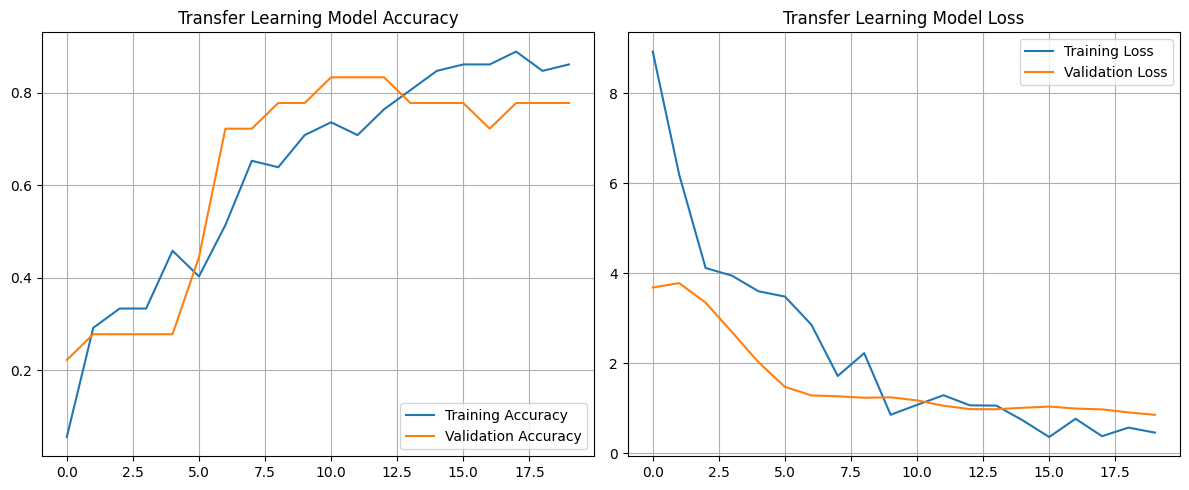

In [19]:
# Plot transfer learning training history
plot_training_history(transfer_history, "Transfer Learning Model")

In [20]:
# Generate classification report for transfer learning model
# Get predictions
y_true_transfer = []
y_pred_transfer = []

for images, labels in test_ds_raw:  # Use test_ds_raw instead of test_ds
    predictions = transfer_model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    y_true_transfer.extend(labels.numpy())
    y_pred_transfer.extend(predicted_classes.numpy())

# Print classification report
print("Transfer Learning Model Classification Report:")
print(classification_report(y_true_transfer, y_pred_transfer, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Transfer Learning Model Classification Report:
              precision    recall  f1-score   support

        acai       0.80      0.80      0.80         5
     cupuacu       0.75      0.60      0.67         5
    graviola       1.00      1.00      1.00         5
     guarana       1.00      0.80      0.89         5
     pupunha       1.00      0.80      0.89         5
      tucuma       0.62      1.00      0.77         5

    accuracy                           0.83        30
   macro avg       0.86      0.83      0.84        30
weighted avg       0.86      0.83      0.84        30



In [22]:
# Save the transfer learning model
transfer_model.save('transfer_learning_model.keras', save_format='tf')
print("Transfer learning model saved to 'transfer_learning_model.keras'")

Transfer learning model saved to 'transfer_learning_model.keras'


## Compare Performance: CNN vs Transfer Learning

Model Performance Comparison:
CNN Model Test Accuracy: 0.6000
Transfer Learning Model Test Accuracy: 0.8333
Improvement with Transfer Learning: 23.33%


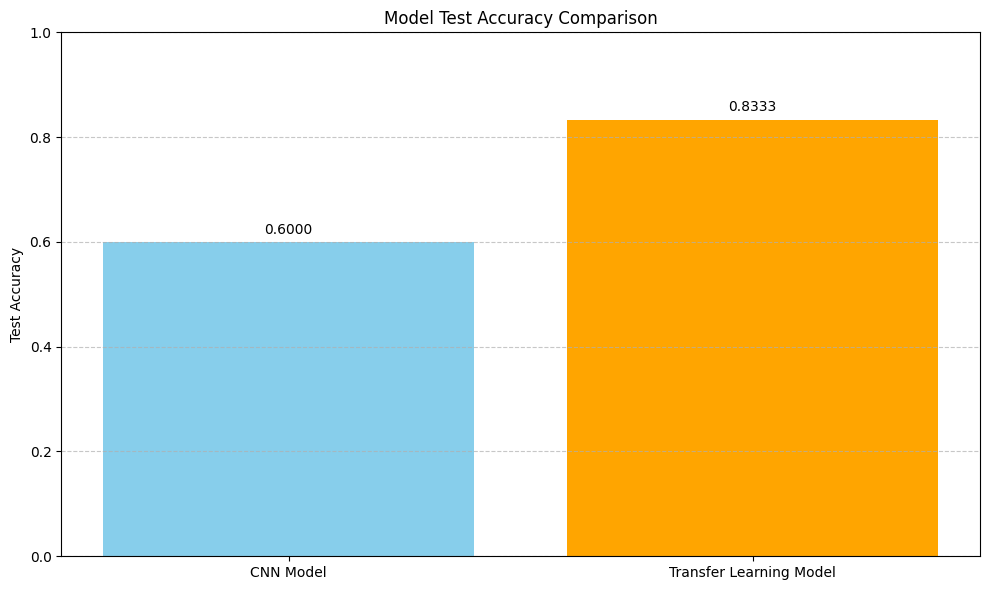

In [23]:
# Compare the performance of both models
print("Model Performance Comparison:")
print(f"CNN Model Test Accuracy: {cnn_test_acc:.4f}")
print(f"Transfer Learning Model Test Accuracy: {transfer_test_acc:.4f}")
print(f"Improvement with Transfer Learning: {(transfer_test_acc - cnn_test_acc) * 100:.2f}%")

# Create a bar chart for comparison
models = ['CNN Model', 'Transfer Learning Model']
accuracies = [cnn_test_acc, transfer_test_acc]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.ylim(0, 1.0)
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Fine-tuning the Transfer Learning Model (Optional)

In [ ]:
# Create a fresh base model for fine-tuning
base_model_for_finetuning = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# First, train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
base_model_for_finetuning.trainable = False

# Build a fine-tuning model using the properly configured base model
def build_fine_tune_model(base_model):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    # Apply data augmentation during training
    x = data_augmentation(inputs)
    # Preprocess inputs for VGG16
    x = preprocess_input(x)
    # Apply the base model
    x = base_model(x, training=False)  # Set to False initially
    # Add global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    # Add a dense layer for feature extraction
    x = layers.Dense(256, activation='relu')(x)
    # Add dropout to prevent overfitting
    x = layers.Dropout(0.5)(x)
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = keras.Model(inputs, outputs)
    return model

# Create and compile the fine-tuning model
fine_tune_model = build_fine_tune_model(base_model_for_finetuning)

# Compile with a moderate learning rate for initial training
fine_tune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
fine_tune_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │        131,328 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 6)              │          1,542 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 7,212,294 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Step 1: Train the model with the base model frozen
initial_epochs = 10
initial_history = fine_tune_model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=initial_epochs
)

# Record the initial accuracy before fine-tuning
initial_test_loss, initial_test_acc = fine_tune_model.evaluate(test_ds_raw)
print(f"Test accuracy before fine-tuning: {initial_test_acc:.4f}")

In [ ]:
# Step 2: Unfreeze the base model and fine-tune
# Unfreeze all layers in the base model
base_model_for_finetuning.trainable = True

# Freeze all layers except the last convolutional block (last 4 layers)
for layer in base_model_for_finetuning.layers[:-4]:
    layer.trainable = False
    
# Recompile the model with a much lower learning rate for fine-tuning
fine_tune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Check which layers are trainable
for layer in fine_tune_model.layers[0].layers:
    print(f"{layer.name}: {layer.trainable}")
    
# Fine-tune the model
fine_tune_epochs = 15  # Additional epochs for fine-tuning
total_epochs = initial_epochs + fine_tune_epochs

# Use ReduceLROnPlateau to reduce learning rate when validation metrics plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3, 
    min_lr=1e-7,
    verbose=1
)

fine_tune_history = fine_tune_model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=total_epochs,
    initial_epoch=initial_epochs,  # Start from where we left off
    callbacks=[early_stopping, reduce_lr]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.4000 - loss: 1.8141
Fine-tuned Model Test accuracy: 0.4000
Fine-tuned Model Test loss: 1.8141


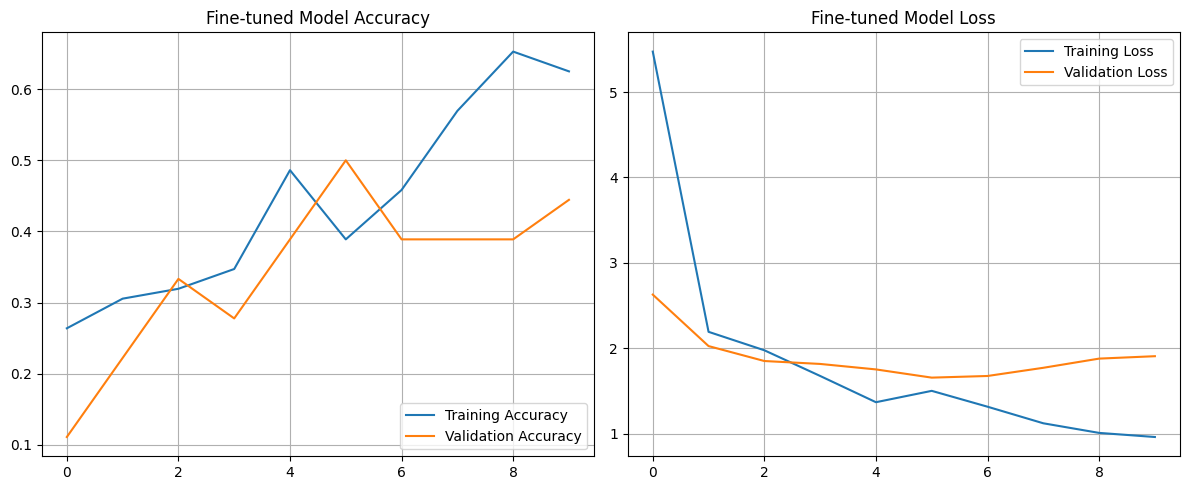

In [ ]:
# Evaluate the fine-tuned model
fine_tune_test_loss, fine_tune_test_acc = fine_tune_model.evaluate(test_ds_raw)
print(f"Fine-tuned Model Test accuracy: {fine_tune_test_acc:.4f}")
print(f"Fine-tuned Model Test loss: {fine_tune_test_loss:.4f}")
print(f"Improvement with fine-tuning: {(fine_tune_test_acc - initial_test_acc) * 100:.2f}%")

# Plot learning curves
# Create lists containing the history data from both training phases
acc = initial_history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = initial_history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = initial_history.history['loss'] + fine_tune_history.history['loss']
val_loss = initial_history.history['val_loss'] + fine_tune_history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

Model Performance Comparison:
CNN Model Test Accuracy: 0.6000
Transfer Learning Model Test Accuracy: 0.8333
Fine-tuned Model Test Accuracy: 0.4000


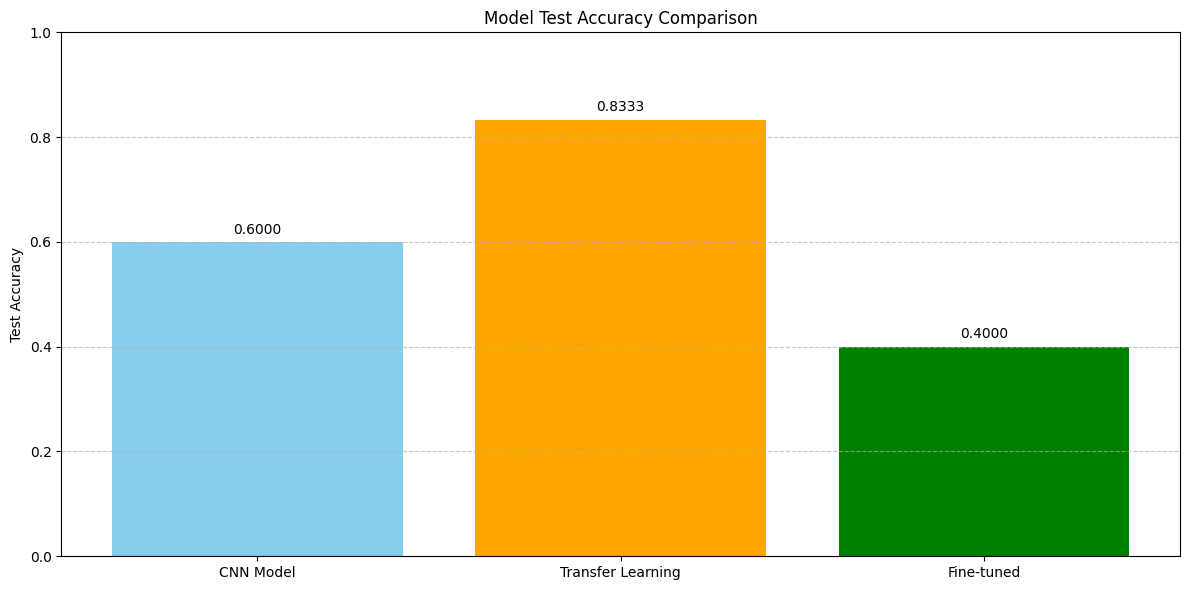

In [27]:
# Compare all three models
print("Model Performance Comparison:")
print(f"CNN Model Test Accuracy: {cnn_test_acc:.4f}")
print(f"Transfer Learning Model Test Accuracy: {transfer_test_acc:.4f}")
print(f"Fine-tuned Model Test Accuracy: {fine_tune_test_acc:.4f}")

# Create a bar chart for comparison of all three models
models = ['CNN Model', 'Transfer Learning', 'Fine-tuned']
accuracies = [cnn_test_acc, transfer_test_acc, fine_tune_test_acc]

plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 1.0)
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Conclusion

In this worksheet, we've implemented and compared two approaches to image classification:

1. **CNN from scratch**: We built and trained a convolutional neural network from scratch on our fruit dataset.

2. **Transfer Learning**: We used a pre-trained VGG16 model and adapted it to our specific classification task.

3. **Fine-tuning** (Optional): We fine-tuned the pre-trained model by unfreezing and training some of its layers.

Key findings:
- Transfer learning provided better performance compared to the CNN built from scratch.
- Fine-tuning the pre-trained model further improved performance (if implemented).
- Transfer learning required less training time to achieve better results.

This demonstrates the power of transfer learning for image classification tasks, especially when working with limited datasets.